In [19]:
!pip install librosa==0.8.0

In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import librosa 
from glob import glob

import random
from functools import partial
import warnings
import IPython.display as ipd
from tensorflow.keras import mixed_precision
warnings.filterwarnings('ignore')

In [21]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [22]:
music_files = glob("/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/*.*.wav")
music_files[:10]

['/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00047.wav',
 '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00021.wav',
 '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00031.wav',
 '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00095.wav',
 '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00012.wav',
 '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00027.wav',
 '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00049.wav',
 '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00088.wav',
 '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00054.wav',
 '/kaggle/

In [ ]:
#Sinusoidal embeddings
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    embedding_max_frequency = 1000.0
    embedding_dims = 32
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings

In [ ]:
#Position Block
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply

In [ ]:
#Down move Block
def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply

In [ ]:
#Up move Block
def UpBlock(width, block_depth, attention=False):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            skip = skips.pop()
            x = layers.Concatenate()([x, skip] if not attention else [
                x, skip, layers.MultiHeadAttention(
                    num_heads=4, key_dim=1, attention_axes=(1,2)
                )(x, skip)
            ])
            x = ResidualBlock(width)(x)
        return x

    return apply

In [23]:
#Network Attention
def get_network(widths, block_depth, dim1=256, dim2=128, channels=1, attention=False):
    noisy_input = keras.Input(shape=(dim1, dim2, channels))
    noise_variances = keras.Input(shape=(1, 1, 1))
    
    upsample_shape = (dim1, dim2)

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=upsample_shape, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_input)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for idx, width in enumerate(reversed(widths[:-1])):
        x = UpBlock(width, block_depth, attention=attention and idx ==0)([x, skips])

    x = layers.Conv2D(channels, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_input, noise_variances], x, name="residual_unet")

In [ ]:
#def signal rates
min_signal_rate = 0.02
max_signal_rate = 0.95
ema = 0.999

In [ ]:
def spectral_norm(pred, real):
    """Calculate difference in spectral norm between two batches of spectrograms."""
    norm_real = tf.norm(real, axis=(1,2)) + 1e-6
    norm_pred = tf.norm(pred, axis=(1,2)) + 1e-6
    return tf.reduce_mean(tf.abs(norm_real - norm_pred) / norm_real)

In [ ]:
def time_derivative(pred, real, window=1):
    real_derivative = real[:, :-window, :, :] - real[:, window:, :, :]
    pred_derivative = pred[:, :-window, :, :] - pred[:, window:, :, :]
    return tf.reduce_mean(tf.keras.losses.MSE(real_derivative, pred_derivative))

In [24]:
#Whole Class for the keras model(keep together)

class DDIM(keras.Model):
    """DDIM model modified from this tutorial: https://keras.io/examples/generative/ddim/"""
    
    def __init__(self, widths, block_depth, attention=False, dim1=256, dim2=128):
        super().__init__()

        self.normalizer = layers.Normalization(axis=(2,3))
        self.network = get_network(widths, block_depth, attention=attention, dim1=dim1, dim2=dim2)
        self.ema_network = keras.models.clone_model(self.network)
        self.spec_mod = 0
        self.dx_mod = 0

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.data_loss_tracker = keras.metrics.Mean(name="d_loss")
        
        self.noise_spec_tracker = keras.metrics.Mean(name="n_spec")
        self.data_spec_tracker = keras.metrics.Mean(name="d_spec")
        
        self.noise_dx_tracker = keras.metrics.Mean(name="n_dx")
        self.data_dx_tracker = keras.metrics.Mean(name="d_dx")
        
        self.noise_total_tracker = keras.metrics.Mean(name="n_total")
        self.data_total_tracker = keras.metrics.Mean(name="d_total")

    @property
    def metrics(self):
        return [
            self.noise_loss_tracker, 
            self.data_loss_tracker,
            
            self.noise_spec_tracker,
            self.data_spec_tracker,
            
            self.noise_dx_tracker,
            self.data_dx_tracker,
            
            self.noise_total_tracker,
            self.data_total_tracker
        ]
    
    def update_trackers(self, n_l, n_s, n_d, d_l, d_s, d_d):
        """Update all loss trackers."""
        n_t = n_l + n_s + n_d
        d_t = d_l + d_s + d_d
        
        for loss, tracker in zip(
            [n_l, n_s, n_d, n_t, d_l, d_s, d_d, d_t], 
            [
                self.noise_loss_tracker, self.noise_spec_tracker, self.noise_dx_tracker, self.noise_total_tracker,
                self.data_loss_tracker, self.data_spec_tracker, self.data_dx_tracker, self.data_total_tracker
            ]
        ):
            tracker.update_state(loss)
            
    def get_losses(self, y_true, y_pred):
        """Get losses for model."""
        return (
            tf.reduce_mean(
                self.loss(y_pred, y_true)
            ), spectral_norm(
                y_pred, y_true
            ), time_derivative(
                y_pred, y_true
            )
        )

    def denormalize(self, data):
        data = self.normalizer.mean + data * self.normalizer.variance**0.5
        return tf.clip_by_value(data, -128.0, 128.0)

    def diffusion_schedule(self, diffusion_times):
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)
        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        return noise_rates, signal_rates

    def denoise(self, noisy_data, noise_rates, signal_rates, training):
        if training:
            network = self.network
        else:
            network = self.ema_network
        pred_noises = network([noisy_data, noise_rates**2], training=training)
        pred_data = (noisy_data - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_data

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        num_examples = tf.shape(initial_noise)[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy data" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_data = initial_noise
        for step in tqdm(range(diffusion_steps)):
            noisy_data = next_noisy_data

            # separate the current noisy data to its components
            diffusion_times = tf.ones((num_examples, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_data = self.denoise(
                noisy_data, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_data = (
                next_signal_rates * pred_data + next_noise_rates * pred_noises
            )
            # this new noisy data will be used in the next step

        return pred_data

    def generate(self, num_examples, shape, diffusion_steps):
        # noise -> data -> denormalized data
        initial_noise = tf.random.normal(shape=(num_examples, shape[0], shape[1], shape[2]))
        generated_data = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_data = self.denormalize(generated_data)
        return generated_data

    def train_step(self, data):
        batch_size = tf.shape(data)[0]
        # normalize data to have standard deviation of 1, like the noises
        data = self.normalizer(data, training=True)
        noises = tf.random.normal(shape=tf.shape(data))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noise_rates = noise_rates
        signal_rates = signal_rates
        # mix the data with noises accordingly
        noisy_data = signal_rates * data + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy data to their components
            pred_noises, pred_data = self.denoise(
                noisy_data, noise_rates, signal_rates, training=True
            )

            noise_loss, noise_spec, noise_dx = self.get_losses(noises, pred_noises) #safe_reduce_mean(self.loss(noises, pred_noises))  # used for training
            total_noise_loss = tf.reduce_sum([
                noise_loss, 
                self.spec_mod*noise_spec, 
                self.dx_mod*noise_dx
            ])
            data_loss, data_spec, data_dx = self.get_losses(data, pred_data) #safe_reduce_mean(self.loss(data, pred_data))  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.update_trackers(
            noise_loss, noise_spec, noise_dx,
            data_loss, data_spec, data_dx
        )

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        # normalize data to have standard deviation of 1, like the noises
        batch_size = tf.shape(data)[0]
        
        data = self.normalizer(data, training=False)
        noises = tf.random.normal(shape=tf.shape(data))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the data with noises accordingly
        noisy_data = signal_rates * data + noise_rates * noises

        # use the network to separate noisy data to their components
        pred_noises, pred_data = self.denoise(
            noisy_data, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        data_loss = self.loss(data, pred_data)

        self.data_loss_tracker.update_state(data_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        return {m.name: m.result() for m in self.metrics}

In [ ]:
def load_at_interval(x, rate=10_000, feats=256, duration=3.3):
    """Load music from file at some offset. Return MDCT spectrogram of that data"""
    file = x[0].numpy().decode()
    idx = x[1].numpy()
    audio, sr = librosa.load(file, duration=duration, sr=rate, offset=idx)
    audio_fill = np.zeros(int(rate*duration), dtype=np.float32)
    audio_fill[:len(audio)] = audio
    spec = tf.signal.mdct(audio_fill, feats)
    return spec


In [ ]:
def load_audio(x,y, rate=10_000, mdct_feats=256, duration=3.3):
    """TF function for loading MDCT spectrogram from file."""
    out = tf.py_function(lambda x,y: load_at_interval( 
        (x,y), rate=rate, feats=mdct_feats, duration=duration
    ), inp=[x,y], Tout=tf.float32)
    return out

In [ ]:
def load_audio(x,y, rate=10_000, mdct_feats=256, duration=3.3):
    """TF function for loading MDCT spectrogram from file."""
    out = tf.py_function(lambda x,y: load_at_interval( 
        (x,y), rate=rate, feats=mdct_feats, duration=duration
    ), inp=[x,y], Tout=tf.float32)
    return out

In [1]:



def get_files_dataset(
        glob_location,
        total_seconds=2,
        out_len = 3.3,
        hop_size=1,
        max_feats = 2048,
        batch_size=4,
        shuffer_size=1000,
        scale=1,
        rate=10_000,
        mdct_feats=256
    ):
    """Get file dataset loader for a glob of audio files."""
    
    files = glob(
        glob_location,
        recursive=True
    )
    
#     files = [file for file in files if file not in exclude]
    
    def file_list_generator():
        for _ in range(total_seconds):
            for file in files:
                yield file, _*hop_size
                
    load_fn = partial(load_audio, duration=out_len, rate=rate, mdct_feats=mdct_feats)
                
    dg =tf.data.Dataset.from_generator(file_list_generator, output_signature = (
        tf.TensorSpec(shape=(), dtype=tf.string), 
        tf.TensorSpec(shape=(), dtype=tf.int32))).shuffle(shuffer_size).map(
            load_fn, num_parallel_calls=tf.data.AUTOTUNE
        ).map(
            lambda x: tf.expand_dims(x, -1)[:max_feats, :, :]*scale
        ).map(
            lambda x: tf.ensure_shape(x, (max_feats, mdct_feats//2, 1))
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dg

In [26]:
dataset = get_files_dataset(
    "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/*.wav", 
    out_len=3.3, 
    max_feats=256, 
    total_seconds=26, 
    scale=1,
    batch_size=16
)

In [27]:
for test_batch in dataset.take(1):
    shape = test_batch.shape

print(shape)

(16, 256, 128, 1)


In [28]:
num_total_examples = (len(music_files) * 26) // shape[0]

In [29]:
model = DDIM(widths = [128, 128, 128, 128], block_depth = 2, 
             attention=True, dim1=shape[1], dim2=shape[2])

In [30]:
model.normalizer.adapt(dataset, steps=10)

In [31]:
model.compile(
    loss=tf.keras.losses.MSE,
    optimizer= tfa.optimizers.AdamW(
        learning_rate = 3e-4,
        weight_decay = 1e-4
    )
)

In [32]:
dataset = dataset.cache()

In [33]:
history = model.fit(dataset.repeat(), steps_per_epoch=num_total_examples, epochs=1)

162/162 [==============================] - 239s 1s/step - n_loss: 0.2125 - d_loss: 2.7629 - n_spec: 0.1676 - d_spec: 2.0573 - n_dx: 0.4158 - d_dx: 5.4447 - n_total: 0.7959 - d_total: 10.2649


In [34]:
model.spec_mod = 1
model.dx_mod = 1

In [35]:
history = model.fit(dataset.repeat(), steps_per_epoch=num_total_examples, epochs=10)

Epoch 1/10
162/162 [==============================] - 231s 1s/step - n_loss: 0.1428 - d_loss: 0.7483 - n_spec: 0.0961 - d_spec: 0.8595 - n_dx: 0.2791 - d_dx: 1.4195 - n_total: 0.5180 - d_total: 3.0273
Epoch 2/10
162/162 [==============================] - 121s 751ms/step - n_loss: 0.1370 - d_loss: 0.6441 - n_spec: 0.0986 - d_spec: 0.8113 - n_dx: 0.2679 - d_dx: 1.2391 - n_total: 0.5035 - d_total: 2.6945
Epoch 3/10
162/162 [==============================] - 121s 749ms/step - n_loss: 0.1256 - d_loss: 0.6090 - n_spec: 0.0885 - d_spec: 0.6761 - n_dx: 0.2460 - d_dx: 1.1537 - n_total: 0.4601 - d_total: 2.4388
Epoch 4/10
162/162 [==============================] - 121s 749ms/step - n_loss: 0.1219 - d_loss: 0.4644 - n_spec: 0.0801 - d_spec: 0.5614 - n_dx: 0.2388 - d_dx: 0.8833 - n_total: 0.4409 - d_total: 1.9092
Epoch 5/10
162/162 [==============================] - 121s 749ms/step - n_loss: 0.1269 - d_loss: 0.4450 - n_spec: 0.0828 - d_spec: 0.6131 - n_dx: 0.2488 - d_dx: 0.8447 - n_total: 0.4586 -

## Generate new samples using this model

In [36]:
specs = model.generate(8, shape[1:], 1000)

100%|██████████| 1000/1000 [02:38<00:00,  6.32it/s]


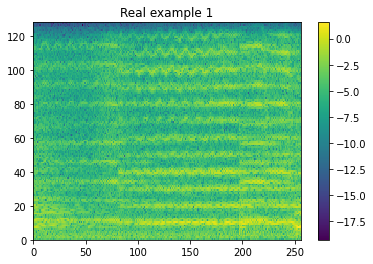

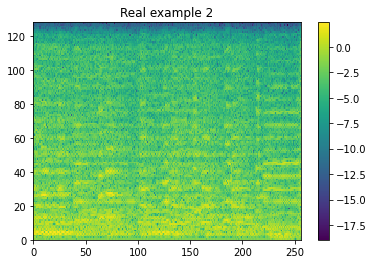

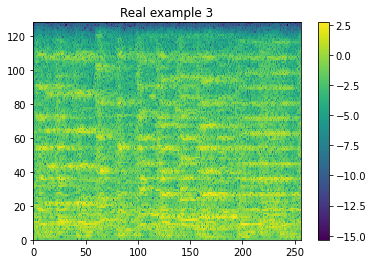

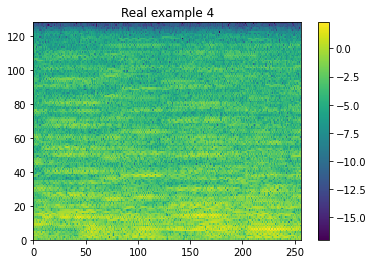

In [37]:
for i in range(4):
    plt.pcolormesh(np.log(np.abs(test_batch[i, :, :, 0].numpy().T)))
    plt.colorbar()
    plt.title(f"Real example {i+1}")
    plt.show()
    ipd.display(ipd.Audio(tf.signal.inverse_mdct(test_batch[i, :, :, 0]), rate=10_000))

### Comparing the generated samples

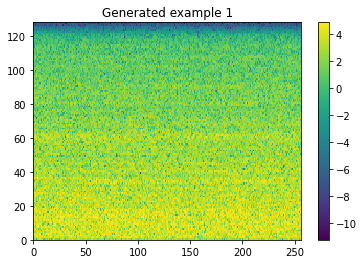

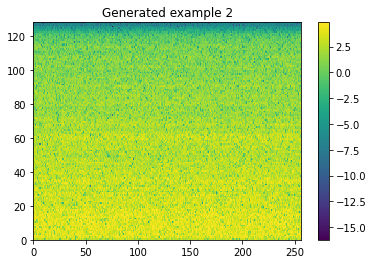

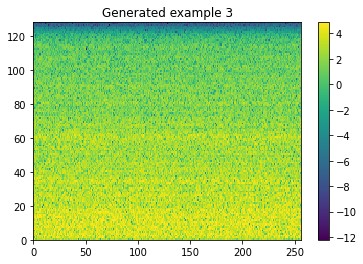

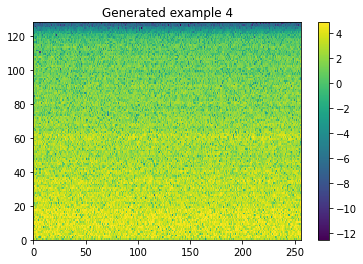

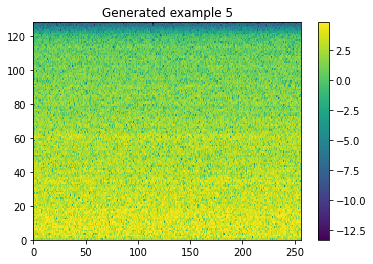

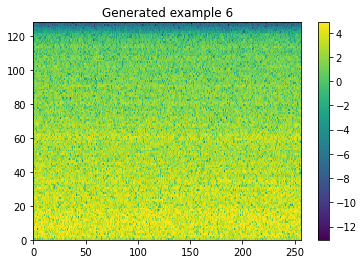

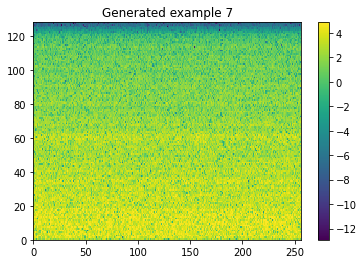

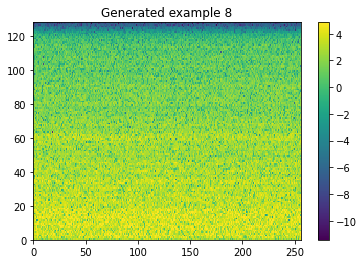

In [38]:
for i in range(len(specs)):
    plt.pcolormesh(np.log(np.abs(specs[i, :, :, 0].numpy().T)))
    plt.colorbar()
    plt.title(f"Generated example {i+1}")
    plt.show()
    ipd.display(ipd.Audio(tf.signal.inverse_mdct(tf.cast(specs[i, :, :, 0], tf.float32)), rate=10_000))